# Сверточная сеть
В этом ноутбуке мы расширим предыдущий и создадим первую сверточную сеть

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
import os
import pandas as pd
from torchvision.io import read_image


# Создание датасета

Загрузим FashionMNIST (https://github.com/zalandoresearch/fashion-mnist)


In [9]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [5]:
def plot_samples(data, labels_map, cols=3, rows=3):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        if type(label) == torch.Tensor:
            plt.title(labels_map[label.item()])
        else:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

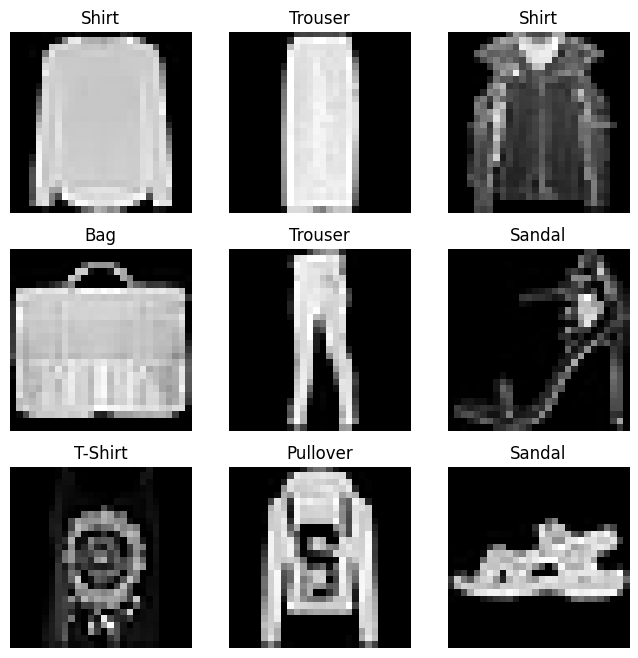

In [6]:
plot_samples(train_data, labels_map, cols=3, rows=3)

Каждый датасет в Pytorch должен наследоваться от класса Dataset и обязательно имплементировать методы `__init__, __len__, __getitem__`. В `__init__` обычно кроме прочего определяются трансформации, которые будут применяться к данным. Это может быть преобразование PIL.Image в тензоры, добавление шума, сдвиги и т.д.
Pytorch предоставляет большое количество трансформаций, но наиболее популярная и удобная библиотека, реализующая трансформации для изображений - *albumentations*. 

`__len__` - должна возвращать размер датасета (например, чисо строк в файле с аннотациями)

`__getitem__` - должен возвращать семпл данных, например, вектор признаков и y. Однако он может возвращать еще и дополнительную информацию, например, y может состоять из набора bboxoв и  сегментационных масок для детекции, класса изображения итп. Обычно возвращается tuple. В целом, возвращаться может любая структура, которую можно представить как набор тензоров, соответствующих одному семплу и входу модели.
Внутри этого метода может происходить загрузка семпла, его трансформации и другие необходимые манипуляции. Очевидно, что он может возвращать не только изображение, но и любые другие данные, и временные ряды, и табличные данные, и облака точек, и другое. 


Реализуем такой датасет для FashionMNIST.

In [7]:
from torchvision.datasets.mnist import read_image_file, read_label_file

In [8]:
class FashionMNISTDataset(Dataset):
    def __init__(self, file_dir, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        self.data = read_image_file(os.path.join(file_dir, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        self.targets = read_label_file(os.path.join(file_dir, label_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Проинициализируйте ваш новый датасет так же, как и ранее встроенный.

In [ ]:
train_data =  # your code
test_data =  # your code

In [ ]:
plot_samples(train_data, labels_map, cols=3, rows=3)

Датасет возвращает один семпл за раз, однако часто наши мощности позволяют обрабатывать больше данных. При работе с таблицами обыно модель получает на вход вообще весь набор сразу или достаточно большими порциями. Когда речь заходит о тензорах и наборах с сотнями тысяч и даже миллионами семплов, это невозможно. На помощь приходит батчевая обработка, когда из датасета берутся небольшие порции данных за раз (используя индекс). За соединение семплов во вход модели отвечает класс DataLoader. Каждую эпоху данные шаффлятся, чтобы уменьшить переобучение. 

In [10]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


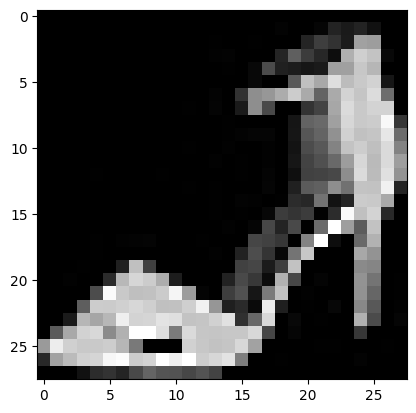

Label: 5


In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().reshape(28,28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Глубокое обучение чаще всего связывают с GPU, и не зря. Имея дело с тензорами и тензорными вычислениями, мы производим огромное количество элементарных операций. Каждое ядро CPU способно произвести только одно вычисление за такт. GPU был создан для обработки графики, где требуется также большое количество простых вычислений, и поэтому может ускорить обработку данных в тысячи раз. Это все должно быть хорошо Вам известно из других курсов)

К сожалению, часто компьютер не поддерживает вычисления на GPU, например, у него просто нет дискретной видеокарты. Pytorch позволяет проводить все операции на CPU, так что его можно использовать где угодно.



In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


*Дополнительное задание: адаптируйте весь код для `accelerate`. Это очень удобная библиотека для адаптации PyTorch кода для любой распределенной конфигурации. Кроме того, она позволяет упростить работу, даже если нам нужно перенести вычисления на GPU или CPU, автоматизируя этот процесс (иначе нам нужно постоянно вызывать `.to(device)`)*
*Для этого импортируйте нужный Accelerator из accelerate. Далее достаточно вызвать accelerator.prepare(elements)*

Теперь создадим класс модели и интстанциируем её. В данном случае это простой перцептрон с тремя слоями. Однако модель может быть сколько угодно сложной. Главное, чтобы она наследовала класс `nn.Module`. Более того, можно написать любой слой собственноручно, также отнаследовав этот класс.
Каждая модель должна имплементировать два метода - `__init__` и `forward(self, *args, **kwargs)`. В первом обычно задается ее структура и другие параметры. Модель  может даже содержать другие модели!

`forward` получает на вход Х, но он может получать несколько разных входов, маски и тд. Обычно возвращаются либо выходы с последнего слоя (один или несколько). Но, например, стандартные модели детекции возвращают в режиме обучения значение лосса, а непосредственные предсказания только в режиме тестирования.

Вызывая `model(data)`, на самом деле мы вызываем именно метод `forward`

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.head = nn.Linear(16*28*28, 10)

    def forward(self, x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        logits = self.head(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (base): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (head): Linear(in_features=12544, out_features=10, bias=True)
)


Слои: http://pytorch.org/docs/nn.html

Активации: http://pytorch.org/docs/nn.html#non-linear-activations

Зададим функцию ошибки и оптимизатор. Функция ошибки также наследуется от torch.nn.Module и может быть стандартной, состоять как из нескольких стандартных функций или их модификаций. Большое количество функций ошибки уже реализовано в Pytorch.

Внутри каждой итерации обучения оптимизация происходит в три этапа:
Вызов optimizer.zero_grad() для обнуления градиентов параметров модели. Градиенты по умолчанию складываются; чтобы избежать двойного подсчета, мы явно обнуляем их на каждой итерации.

Получение градиентов для каждого веса с помощью loss.backward().
Как только мы получили наши градиенты, остается вызвать optimizer.step(), чтобы изменить параметры в соответствии с нашим алгоритмом оптимизации. 

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Обучим модель. Для этого нужно описать цикл обучения и проверки модели. В наивном случае создается две функции train и validate (test), которые вызываются в цикле по эпохам. В дальнейшем, при усложнении прохода по эпохе, может появиться метод train, целый класс Trainer и т.д. Пока что реализуем наивный вариант.

In [36]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute prediction error
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        ''' Чтобы сделать задание со сравнением лоссов, не забудьте 
            реализовать трекинг минимального лосса  '''

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            preds = model(inputs)
            test_loss += loss_fn(preds, targets)
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
    test_loss /= num_batches
    num_correct /= size
    print(f"Test Error: \n Accuracy: {(100*num_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    ''' Чтобы сделать задание со сравнением лоссов, не забудьте 
            реализовать трекинг минимального лосса  '''

Задание: Добавьте метрики precision и recall для проверки

In [38]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    test(dataloader=train_dataloader, model=model, loss_fn=loss_fn)

Epoch 1
-------------------------------
loss: 2.334135  [   64/60000]
loss: 0.864156  [ 6464/60000]
loss: 0.503208  [12864/60000]
loss: 0.585873  [19264/60000]
loss: 0.623312  [25664/60000]
loss: 0.665746  [32064/60000]
loss: 0.486447  [38464/60000]
loss: 0.428994  [44864/60000]
loss: 0.545600  [51264/60000]


KeyboardInterrupt: 

Осталось сохранить модель для дальнейшего использования. 

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

Задание: придумайте свою собственную модель, на следующем занятии сравнимся, у кого получилось достичь наилучших результатов.

Задание: Перепишите датасет FashionMNISTDataset так, чтобы он возвращал вектор вместо матрицы